# Assignment 4. Deep Learning and Generative models

**Foundations of Data Science**  
*Dr. Khalaj (Fall 2024)*  

*For your questions refer iman1234ahmadi@gmail.com or @imoon_a on Telegram*

In [ ]:
Name = "Leili Motahari"
Student_id = ""

##  **Part 1 : Transfer Learning**

### 1. 1. Loading Packages


In [ ]:
# Import the required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')


### 1. 2. Load and Explore Data

In [ ]:
!wget -O data.zip https://www.dropbox.com/scl/fi/x9wbnxox44rey6xym4un7/data.zip?rlkey=uo2pos87olc6zgkdhp5dcverb&raw=1
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

You will notice that you have three subfolders inside `chest_xray`: train, test, and validation. These will be used for building and evaluating your model's performance. Within each of these folders, you have two subfolders: **NORMAL** and **PNEUMONIA**.

#### 1. 2. 1. The path's variables below point to the negative and positive instances of the training and testing sets (folders). We will use these to check the class distribution in our dataset. In other words, how many positive and negative instances are available. Recall, a hugely imbalanced dataset can lead to biased results.
5 Points

In [ ]:
train_dir = os.path.join('chest_xray', 'train')
test_dir  = os.path.join('chest_xray', 'test')

#### 1. 2. 2. Now create a function to load data to Python.

10 Points

In [ ]:
def load_data_and_show_distribution():
    train_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
    train_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
    test_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
    test_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))

    print("Train Distribution:")
    print("  Normal (0):    ", train_normal)
    print("  Pneumonia (1): ", train_pneumonia)

    print("\nTest Distribution:")
    print("  Normal (0):    ", test_normal)
    print("  Pneumonia (1): ", test_pneumonia)



 #### 1. 2. 3. show the class distributions (0 denotes a normal image, while 1 denotes an image depicting pneumonia) in train and test.
 5 Points

In [ ]:
load_data_and_show_distribution()

Train Distribution:
  Normal (0):     1341
  Pneumonia (1):  3875

Test Distribution:
  Normal (0):     234
  Pneumonia (1):  390


 #### 1. 2. 4. Write a function to show arbitray number of normal or pneumonia images.
 10 Points

In [ ]:
def display_images(category='NORMAL', dataset='train', num_images=5):
    """
    Displays a given number of images from a specified category and dataset split,
    applying histogram equalization for improved contrast.

    Parameters:
      category: 'NORMAL' or 'PNEUMONIA'
      dataset:  'train', 'test', or 'validation'
      num_images: Number of random images to display
    """
    
    folder = os.path.join('chest_xray', dataset, category)
    image_files = os.listdir(folder)
    selected_files = np.random.choice(image_files, num_images, replace=False)

    plt.figure(figsize=(15,5))

    for i, file in enumerate(selected_files):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_eq = cv2.equalizeHist(img)

        plt.subplot(1, num_images, i+1)
        plt.imshow(img_eq, cmap='gray')
        plt.title(f'{category} image')
        plt.axis('off')

    plt.show()


 #### 1. 2. 5. apply histogram equalization to improve images contrast for better visualisation (more about this technique can be found [here](https://homepages.inf.ed.ac.uk/rbf/HIPR2/histeq.htm) and [here](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist). this gives a better visualisation of the images:
 10 Points

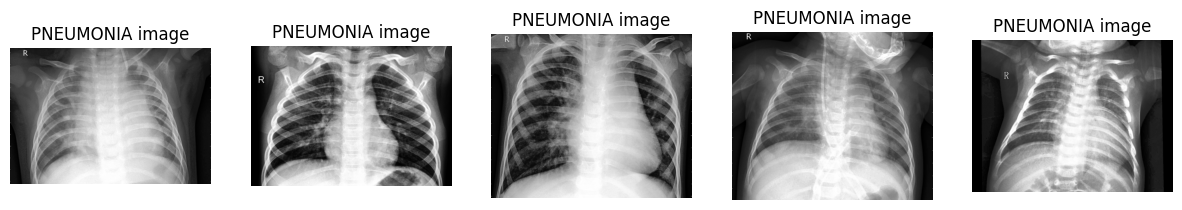

In [ ]:
display_images(category='PNEUMONIA', dataset='train', num_images=5)

#### 1. 2.6 Use ImageDataGenerator to augment image data by applying random transformations. This is often used in deep learning pipelines to artificially expand the size of the training dataset and improve the model's generalization.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(os.path.join('chest_xray', 'train'), transform=train_transforms)
test_dataset = ImageFolder(os.path.join('chest_xray', 'test'), transform=test_transforms)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

### 2. 1. Build a Vanilla CNN Model


First step, arrange the data in different constructs (x_train, y_train, x_test, y_test, x_val,y_val), etc...):

5 Points

In [ ]:
train_dir = os.path.join('chest_xray', 'train')
val_dir   = os.path.join('chest_xray', 'val')
test_dir  = os.path.join('chest_xray', 'test')

train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset   = ImageFolder(val_dir, transform=test_transforms)
test_dataset  = ImageFolder(test_dir, transform=test_transforms)

print("Original training class distribution (labels 0: NORMAL, 1: PNEUMONIA):")
train_targets = train_dataset.targets
print(np.bincount(train_targets))

class_counts = np.bincount(train_targets)
class_weights = 1. / class_counts  
sample_weights = [class_weights[t] for t in train_targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Original training class distribution (labels 0: NORMAL, 1: PNEUMONIA):
[1341 3875]


#### 2. 1.1. CNN Model
defines a CNN model with more than 18 layer.

1. Notice the **BatchNormalization** layer that is added to the model. This is often used to speed up the training process and make it more stable. It does so by normalizing the inputs from hidden layers.

2. The **Droput** layer: is used to prevent overfitting of the model. It does this by setting some input units to 0 during the training process (e.g. switching off some neurons in the network).

15 Points

In [ ]:
class VanillaCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(VanillaCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1: 3 conv layers (3 -> 64)
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: 5 conv layers (64 -> 128)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # extra conv layer here
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: 4 conv layers (128 -> 256)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4: 4 conv layers (256 -> 512)
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5: 3 conv layers (512 -> 512)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x


#### 2. 1.2. Running The Model

Beafore runing the model use must fix the Imbalance Problem. please write a good solution and apply it to the Data.

10 Points

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VanillaCNN(num_classes=2).to(device)
print(model)

VanillaCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, e

Train the Model on the train data.

10 Points

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")


Epoch 1/20, Train Loss: 0.3320, Val Loss: 0.6423
Epoch 2/20, Train Loss: 0.2421, Val Loss: 1.8033
Epoch 3/20, Train Loss: 0.1893, Val Loss: 0.8322
Epoch 4/20, Train Loss: 0.1444, Val Loss: 1.2953
Epoch 5/20, Train Loss: 0.1433, Val Loss: 0.6398
Epoch 6/20, Train Loss: 0.1337, Val Loss: 0.5125
Epoch 7/20, Train Loss: 0.1236, Val Loss: 1.7699
Epoch 8/20, Train Loss: 0.1202, Val Loss: 0.4064
Epoch 9/20, Train Loss: 0.1128, Val Loss: 0.7099
Epoch 10/20, Train Loss: 0.1159, Val Loss: 1.4948
Epoch 11/20, Train Loss: 0.1143, Val Loss: 0.5414
Epoch 12/20, Train Loss: 0.1091, Val Loss: 0.3758
Epoch 13/20, Train Loss: 0.1003, Val Loss: 1.4123
Epoch 14/20, Train Loss: 0.0973, Val Loss: 0.8991
Epoch 15/20, Train Loss: 0.0959, Val Loss: 0.2457
Epoch 16/20, Train Loss: 0.0919, Val Loss: 1.3064
Epoch 17/20, Train Loss: 0.0945, Val Loss: 0.4585
Epoch 18/20, Train Loss: 0.0865, Val Loss: 0.8388
Epoch 19/20, Train Loss: 0.0779, Val Loss: 0.4402
Epoch 20/20, Train Loss: 0.0916, Val Loss: 0.5130


show and plot the loss curve for training and validation.

10 Points

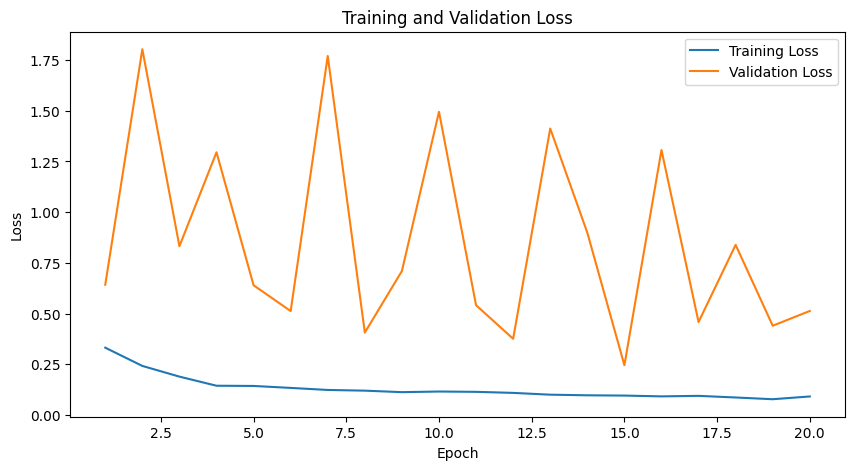

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


evaluate the model on test data.

5 Points

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

test_accuracy = correct / total
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


Test Accuracy: 77.56%


### 3.1. Transfer Learning


#### 3.1.1. Pre-trained models

Here, we will use a pre-trained model to perform classification (Transfer Learning). Various models such as VGG16, XCeption,ResNet152V2, etc... can be used.Use one of this models.

Also notice that these models have been trained using large number of images.

30 Points

=== Transfer Learning (Frozen Pre-trained Layers) ===
Epoch 1/10, Loss: 0.4543
Epoch 2/10, Loss: 0.3110
Epoch 3/10, Loss: 0.2746
Epoch 4/10, Loss: 0.2687
Epoch 5/10, Loss: 0.2567
Epoch 6/10, Loss: 0.2493
Epoch 7/10, Loss: 0.2584
Epoch 8/10, Loss: 0.2557
Epoch 9/10, Loss: 0.2327
Epoch 10/10, Loss: 0.2337


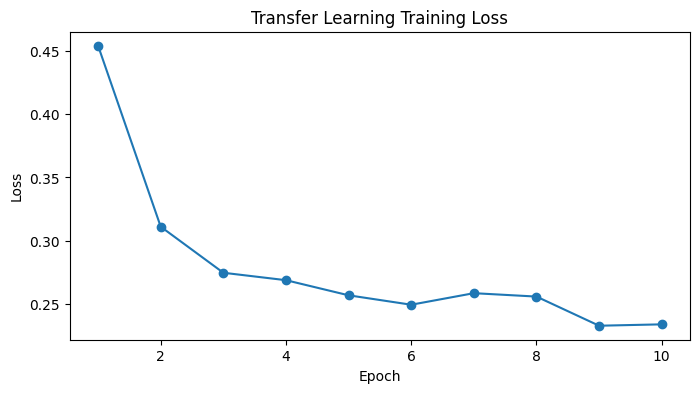

In [ ]:
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_features = model.classifier[6].in_features  
model.classifier[6] = nn.Linear(num_features, 2)  
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

num_epochs = 10
train_losses = []

print("=== Transfer Learning (Frozen Pre-trained Layers) ===")
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transfer Learning Training Loss')
plt.show()


#### 3.1.2. show the confusion matrix for test data.

5 Points

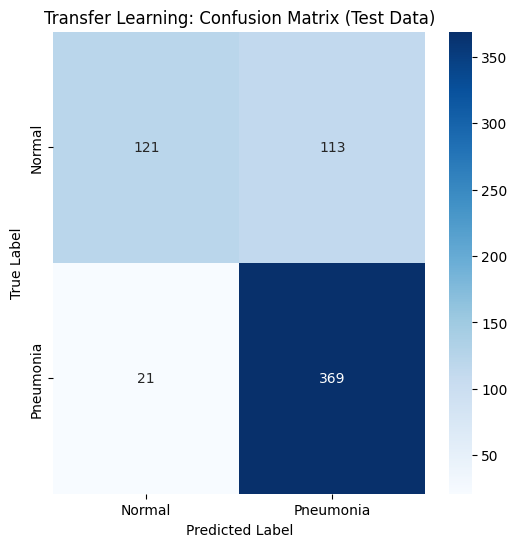

Transfer Learning Test Accuracy: 78.53%


In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Transfer Learning: Confusion Matrix (Test Data)')
plt.show()

accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Transfer Learning Test Accuracy: {accuracy*100:.2f}%")

### 4.1. Fine-tuning models
Notice that when we used pre-trained models, we haven't changed the weights, or retrained any of the Models layers. Simply put, we have updated the input and output of the models, while keeping all layers of the pre-trained models frozen. Although this is useful, in some cases you need to train some of the layers (update the weights of the model), and this is what is called fine-tuning the models. Here, you must going to unfreeze some layers and retrain. Note also, that we often keep lower layers frozen, because these capture generic features that may be shared with most images.

25 Points


=== Fine-Tuning (Unfreezing Later Layers) ===
Epoch 1/10, Loss: 0.1804
Epoch 2/10, Loss: 0.1123
Epoch 3/10, Loss: 0.0844
Epoch 4/10, Loss: 0.0727
Epoch 5/10, Loss: 0.0705
Epoch 6/10, Loss: 0.0527
Epoch 7/10, Loss: 0.0510
Epoch 8/10, Loss: 0.0413
Epoch 9/10, Loss: 0.0398
Epoch 10/10, Loss: 0.0486


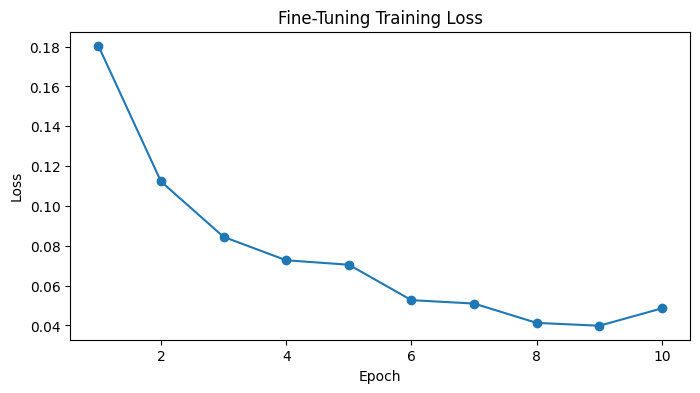

In [ ]:
model_ft = models.vgg16(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_features = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_features, 2)
for param in model_ft.features[24:].parameters():
    param.requires_grad = True

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=1e-4)

num_epochs = 10
train_losses_ft = []

print("=== Fine-Tuning (Unfreezing Later Layers) ===")
model_ft.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_ft.zero_grad()
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses_ft.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), train_losses_ft, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fine-Tuning Training Loss')
plt.show()



Evaluate the model on test data.

5 Points

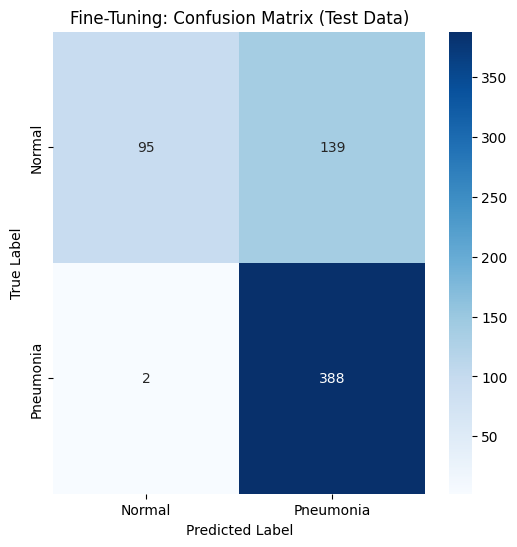

Fine-Tuning Test Accuracy: 77.40%


In [ ]:
model_ft.eval()
all_preds_ft = []
all_labels_ft = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_ft.extend(preds.cpu().numpy())
        all_labels_ft.extend(labels.cpu().numpy())

cm_ft = confusion_matrix(all_labels_ft, all_preds_ft)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Fine-Tuning: Confusion Matrix (Test Data)')
plt.show()

accuracy_ft = np.sum(np.array(all_preds_ft) == np.array(all_labels_ft)) / len(all_labels_ft)
print(f"Fine-Tuning Test Accuracy: {accuracy_ft*100:.2f}%")

##  **Part 2 : Generative models**

> For possible questions, refer to *@aradmnk* on Telegram or *aradkashani@yahoo.com*.

In this part, we are interested in making a generative [VQ-VAE](https://arxiv.org/pdf/1711.00937) model using the CIFAR-10 dataset.

### Import libraries

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# and more, if needed
import torchvision.datasets as datasets
import torchvision


### Load/download the CIFAR-10 dataset

In [73]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !cat ~/.kaggle/kaggle.json
# %cd /content/
# !kaggle datasets download petitbonney/cifar10-image-recognition

In [74]:
# path = '/content/'

# import zipfile
# with zipfile.ZipFile(path+ "/" +'cifar10-image-recognition.zip', 'r') as zip_ref:
#     zip_ref.extractall(path)

In [ ]:
batch_size = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


### Define the VQ-VAE model

#### Encoder

You may refer to the paper to mimic their architecture. Nonetheless, here is what the you are meant to implement:

1. **Initialize Convolutional Layers**:
   - **Strided Convolutional Layers**:
     - Create the first strided convolutional layer (`self.strided_conv_1`) to down-sample the input images. This layer should have `input_dim` input channels, `hidden_dim` output channels, and a kernel size of `kernel_1` (e.g., 4). Use a stride of 2 and set the padding to 1.
     - Create the second strided convolutional layer (`self.strided_conv_2`) to further down-sample the images. This layer should have `hidden_dim` input and output channels, and a kernel size of `kernel_2` (e.g., 4). Use a stride of 2 and set the padding to 1.
   
   - **Residual Convolutional Layers**:
     - Create the first residual convolutional layer (`self.residual_conv_1`) to maintain the feature map size. This layer should have `hidden_dim` input and output channels, and a kernel size of `kernel_3` (e.g., 3). Set the padding to 1.
     - Create the second residual convolutional layer (`self.residual_conv_2`) for further processing. This layer should have `hidden_dim` input and output channels, and a kernel size of `kernel_4` (e.g., 1). Set the padding to 0.
   
   - **Projection Layer**:
     - Create a projection layer (`self.proj`) to map the hidden features to the desired output dimensions. This layer should have `hidden_dim` input channels and `output_dim` output channels, and a kernel size of 1.

2. **Implement the Forward Pass**:
   - **Apply Strided Convolutions**:
     - Pass the input tensor `x` through the first strided convolutional layer (`self.strided_conv_1`).
     - Pass the resulting tensor through the second strided convolutional layer (`self.strided_conv_2`).
   
   - **Apply Activation Function**:
     - Apply an activation function to the tensor obtained from the strided convolutions. ReLU is a fine choice.
   
   - **Apply Residual Convolutions**:
     - Pass the activated tensor through the first residual convolutional layer (`self.residual_conv_1`).
     - Add the result of the residual convolution to the original activated tensor (`y + x`).
     - Apply the ReLU activation function to this result.
     - Pass the resulting tensor through the second residual convolutional layer (`self.residual_conv_2`).
     - Add the result of the second residual convolution to the tensor from the previous step (`y + x`).
   
   - **Apply Projection**:
     - Pass the final tensor through the projection layer (`self.proj`) to obtain the encoded output.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        """
        Args:
            input_dim (int): number of input channels (e.g., 3 for CIFAR-10).
            hidden_dim (int): number of hidden channels.
            output_dim (int): number of output channels (the latent dimension).
            kernel_size (tuple): (k1, k2, k3, k4).
            stride (int): stride for the strided convolutions.
        """
        super(Encoder, self).__init__()
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size

        # Strided Convolutional Layers
        self.strided_conv_1 = nn.Conv2d(
            in_channels=input_dim,
            out_channels=hidden_dim,
            kernel_size=kernel_1,
            stride=stride,
            padding=1
        )

        self.strided_conv_2 = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=kernel_2,
            stride=stride,
            padding=1
        )

        # Residual Convolutional Layers
        self.residual_conv_1 = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=kernel_3,
            stride=1,
            padding=1
        )

        self.residual_conv_2 = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=kernel_4,
            stride=1,
            padding=0
        )

        # Projection Layer
        self.proj = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=output_dim,
            kernel_size=1,
            stride=1,
            padding=0
        )

    def forward(self, x):
    
        x = self.strided_conv_1(x)      
        x = self.strided_conv_2(x)      
        x = F.relu(x)

        # First residual block
        residual = x
        y = self.residual_conv_1(x)     
        y = y + residual
        y = F.relu(y)

        # Second residual block
        residual = y
        y = self.residual_conv_2(y)
        y = y + residual
        z = self.proj(y)  

        return z


#### VQEmbeddingEMA

Implement the `VQEmbeddingEMA` class to perform vector quantization with Exponential Moving Average (EMA) updates for embedding vectors.


1. **Initialization**:
    - Initialize the class with parameters: `n_embeddings`, `embedding_dim`, `commitment_cost`, `decay`, and `epsilon`.
    - Create and initialize the embedding matrix with uniform distribution values.
    - Register buffers for `embedding`, `ema_count`, and `ema_weight`.
    - `embedding` should have dimensions `(n_embeddings, embedding_dim)`.
    - Initialize `ema_count` to zeros with shape `(n_embeddings)`.
    - Clone the `embedding` matrix to create `ema_weight`.

2. **Encoding Function**:
    - Implement the `encode` method to perform the quantization process:
        - Flatten the input tensor `x` to shape `(batch_size * seq_length, embedding_dim)`.
        - Calculate the squared Euclidean distances between `x_flat` and the embedding vectors.
        - Find the indices of the nearest embedding vectors.
        - Use these indices to obtain the quantized tensor.
        - Reshape the quantized tensor to match the input tensor’s shape and return it along with the indices.

3. **Retrieve Random Codebook**:
    - Use the provided random indices to retrieve and return the corresponding quantized embeddings, transposed as required.

4. **Forward Pass**:
    - Implement the `forward` method to compute the forward pass:
        - Flatten the input tensor `x` similarly as in the `encode` method.
        - Calculate distances and find the closest embeddings.
        - One-hot encode the indices and obtain the quantized embeddings.
        - During training:
            - Update `ema_count` using the EMA formula.
            - Normalize `ema_count` and update `ema_weight` with the new encodings.
            - Update the embedding vectors using `ema_weight` and `ema_count`.
        - Compute the codebook and commitment losses using MSE.
        - Combine the quantized and original tensors.
        - Calculate the perplexity to measure the diversity of the encodings.
        - Return the quantized tensor, commitment loss, codebook loss, and perplexity.

In [ ]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        """
        n_embeddings: number of codebook vectors
        embedding_dim: dimensionality of each embedding vector
        commitment_cost: beta parameter for commitment loss
        decay: EMA decay
        epsilon: small constant for stability
        """
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

     
        init_bound = 1.0 / n_embeddings
        embedding = torch.empty(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)

        self.register_buffer("embedding", embedding)       
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", embedding.clone())

    def encode(self, x: torch.Tensor):
        """
        Encode input x to its nearest embeddings.

        x shape: (B, embedding_dim, H, W).
        We will flatten the spatial dimensions, compute distances, get indices,
        then return both quantized and indices.
        """
        B, C, H, W = x.shape

        
        x_perm = x.permute(0, 2, 3, 1).contiguous() 
        x_flat = x_perm.view(-1, C)                  
        distances = (
            torch.sum(x_flat**2, dim=1, keepdim=True)
            - 2 * x_flat @ self.embedding.t()
            + torch.sum(self.embedding**2, dim=1)
        )  

        indices = torch.argmin(distances, dim=1)  

        quantized_flat = F.embedding(indices, self.embedding)  
        quantized = quantized_flat.view(B, H, W, C).permute(0, 3, 1, 2).contiguous()

        return quantized, indices.view(B, H, W)

    def retrieve_random_codebook(self, random_indices):
        """
        Provided as-is in the instructions.
        random_indices shape: (batch_size, any, any)
        This just looks up embedding and transposes.
        """
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        return quantized

    def forward(self, x):
        """
        Vector-quantize x and update EMA statistics.
        x shape: (B, embedding_dim, H, W)

        Returns:
            quantized : quantized version of x
            commitment_loss
            codebook_loss
            perplexity
        """
        quantized, indices = self.encode(x)

        if self.training:
           
            B, C, H, W = x.shape
            flat_indices = indices.view(-1)  
            encodings = F.one_hot(flat_indices, num_classes=self.embedding.size(0)).type(x.dtype)
            
            encodings_sum = torch.sum(encodings, dim=0)
            self.ema_count = self.ema_count * self.decay + encodings_sum * (1 - self.decay)

            n = torch.sum(self.ema_count)
            self.ema_count = (
                (self.ema_count + self.epsilon)
                / (n + self.embedding.size(0) * self.epsilon) * n
            )

            x_flat = x.permute(0, 2, 3, 1).contiguous().view(-1, C)  
            dw = encodings.t() @ x_flat 

            self.ema_weight = self.ema_weight * self.decay + dw * (1 - self.decay)
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(1)
        commitment_loss = self.commitment_cost * F.mse_loss(x, quantized.detach())
        codebook_loss = F.mse_loss(x.detach(), quantized)

        encodings = indices.view(-1)
        encodings_oh = F.one_hot(encodings, num_classes=self.embedding.size(0)).float()
        avg_probs = torch.mean(encodings_oh, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity


#### Decoder

This is just like the encoder, but in reverse.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        """
        Args:
            input_dim (int): latent dimension from the encoder
            hidden_dim (int): number of hidden channels
            output_dim (int): final number of channels (3 for RGB)
            kernel_sizes (tuple): (k1, k2, k3, k4)
            stride (int): stride for transposed convolutions
        """
        super(Decoder, self).__init__()
        k1, k2, k3, k4 = kernel_sizes


        self.proj = nn.Conv2d(input_dim, hidden_dim, kernel_size=k1, stride=1, padding=0)
        self.residual_conv_1 = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=k2,
            stride=1,
            padding=1
        )
        self.residual_conv_2 = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=k2,
            stride=1,
            padding=1
        )

        self.trans_conv_1 = nn.ConvTranspose2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=k3,
            stride=stride,
            padding=0
        )
        self.trans_conv_2 = nn.ConvTranspose2d(
            in_channels=hidden_dim,
            out_channels=output_dim,
            kernel_size=k4,
            stride=stride,
            padding=0
        )

    def forward(self, x):
        # Project
        x = self.proj(x)         
        x = F.relu(x)

        # First residual
        res = x
        y = self.residual_conv_1(x)
        y = y + res
        y = F.relu(y)

        # Second residual
        res = y
        y = self.residual_conv_2(y)
        y = y + res
        y = F.relu(y)

        # Upsample
        y = self.trans_conv_1(y) 
        y = F.relu(y)

        y = self.trans_conv_2(y) 

        return y


#### The end-to-end model

This is the model you are meant to train.

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder

    def forward(self, x):
        # Encode
        z = self.encoder(x)  

        # Vector Quantize
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)

        # Decode
        x_hat = self.decoder(z_quantized)

        return x_hat, commitment_loss, codebook_loss, perplexity


In [ ]:
input_dim = 3
hidden_dim = 512
latent_dim = 16       
n_embeddings = 512
output_dim = 3

encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=latent_dim)
decoder = Decoder(input_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)


### Define loss function (reproduction loss) and optimizer

In [ ]:
def reconstruction_loss(x, x_hat):
    return F.mse_loss(x_hat, x)

### Train your model!

In [ ]:
lr = 2e-4
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))


for epoch in range(epochs):
    model.train()
    running_recon_loss = 0.0
    running_commit_loss = 0.0
    running_codebook_loss = 0.0
    running_total = 0.0

    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(DEVICE)

        optimizer.zero_grad()

        x_hat, commit_loss, codebook_loss, perplexity = model(images)
        recon_loss = reconstruction_loss(images, x_hat)
        loss = recon_loss + commit_loss + codebook_loss

        loss.backward()
        optimizer.step()

        running_recon_loss += recon_loss.item()
        running_commit_loss += commit_loss.item()
        running_codebook_loss += codebook_loss.item()
        running_total       += loss.item()

    num_batches = len(train_loader)
    print(f"[Epoch {epoch+1}] "
          f"Recon: {running_recon_loss/num_batches:.4f} | "
          f"Commit: {running_commit_loss/num_batches:.4f} | "
          f"Codebook: {running_codebook_loss/num_batches:.4f} | "
          f"Total: {running_total/num_batches:.4f}")


Epoch 1/50:   0%|          | 1/391 [00:00<04:57,  1.31it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

### Evaluate your model

Report your `perplexity`, `commit_loss` and `codebook_loss` in the test set.

In [ ]:
model.eval()
test_recon = 0.0
test_commit = 0.0
test_codebook = 0.0
test_perplex = 0.0

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(DEVICE)
        x_hat, commit_loss, codebook_loss, perplexity = model(images)

        # Reconstruction
        recon_loss = F.mse_loss(x_hat, images)
        test_recon += recon_loss.item()
        test_commit += commit_loss.item()
        test_codebook += codebook_loss.item()
        test_perplex += perplexity.item()

num_test_batches = len(test_loader)
print(f"Test Reconstruction Loss: {test_recon / num_test_batches:.4f}")
print(f"Test Commitment Loss:    {test_commit / num_test_batches:.4f}")
print(f"Test Codebook Loss:      {test_codebook / num_test_batches:.4f}")
print(f"Test Perplexity:         {test_perplex / num_test_batches:.4f}")


Now, draw some of the test set and their reconstructed counterparts in a grid.

In [ ]:
def visualize_reconstructions(model, loader, num_images=8):
    model.eval()
    images, _ = next(iter(loader))
    images = images.to(DEVICE)

    with torch.no_grad():
        x_hat, _, _, _ = model(images)

 
    images = images[:num_images]
    x_hat = x_hat[:num_images]
    original_grid = make_grid(images, nrow=4, normalize=True, value_range=(-1, 1))
    recon_grid = make_grid(x_hat, nrow=4, normalize=True, value_range=(-1, 1))
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(original_grid.permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Original")
    axs[0].axis('off')

    axs[1].imshow(recon_grid.permute(1, 2, 0).cpu().numpy())
    axs[1].set_title("Reconstructed")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


visualize_reconstructions(model, test_loader, num_images=8)


### Generate

Now, generate new pictures. First generate `batch_size//2` random integer indices from 0 to `n_embeddings`, then you may use `retrieve_random_codebook` from your codebook and finally the decoder to generate new images.

Are your generated samples meaningful? If not, can you find a reason in your sampling method?

### optional

The VQ-VAE (Vector Quantized Variational Autoencoder) struggles to produce high-quality generations in some cases due to its reliance on the prior model used to sample the latent space. Specifically, after training the VQ-VAE, the quality of the generated data heavily depends on how well the chosen prior model (e.g., an autoregressive model like PixelCNN) can capture the distribution of the latent space. If the autoregressive model doesn't fully learn the latent distribution, it can result in suboptimal generations, as the latent representations fed into the decoder won't align well with meaningful or realistic patterns.

Your task is to propose a solution and implement it to achieve better results in generation.
